# random_forest_model.ipynb

## Notebook Purpose
This notebook is designed to develop and train a Random Forest model using the preprocessed cryptocurrency data. The trained model will be used for making predictions in subsequent notebooks. This approach allows us to leverage the ensemble learning capabilities of Random Forests to make more accurate predictions.

## Instructions
1. **Import Necessary Libraries**:
   - Import `pandas` for data manipulation.
   - Import `train_test_split` from `sklearn.model_selection` for splitting the data.
   - Import `RandomForestRegressor` from `sklearn.ensemble` for the model.
   - Import `joblib` for saving the trained model.

2. **Load Preprocessed Data**:
   - Load the preprocessed CSV file created in the previous notebooks.

3. **Train the Random Forest Model**:
   - Split the data into training and testing sets.
   - Train the Random Forest model on the historical data.

4. **Save the Trained Model**:
   - Save the trained model to a file for later use in making predictions.

5. **Evaluate Model Performance**:
   - Evaluate the model's performance using appropriate metrics (e.g., R^2 score).

## Example Code
```python
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import joblib

# Load preprocessed data
data_path = 'data/historical_data/btc_usd_preprocessed.csv'  # Update this path based on the selected cryptocurrency
data = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')

# Split the data into training and testing sets
X = data[['Open', 'High', 'Low', 'Close', 'Volume']]
y = data['Close'].shift(-1).dropna()
X = X[:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, 'models/random_forest_model.pkl')

# Display model performance
print(f"Model trained. R^2 score on test data: {model.score(X_test, y_test)}")


In [1]:
# Cell 1: Imports
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore")

print("Libraries imported successfully.")


Libraries imported successfully.


In [2]:
# Cell 2: Load preprocessed data
data_paths = {
    'BTC': '../data/cleaned_data/BTC_cleaned.csv',
    'ETH': '../data/cleaned_data/ETH_cleaned.csv',
    'SOL': '../data/cleaned_data/SOL_cleaned.csv'
}

crypto_data = {crypto: pd.read_csv(path, parse_dates=['Date'], index_col='Date') for crypto, path in data_paths.items()}
print("Data loaded successfully for BTC, ETH, and SOL.")


Data loaded successfully for BTC, ETH, and SOL.


In [3]:
# Cell 3: Create lagging features
def create_lagged_features(data, num_lags=7):
    for i in range(1, num_lags + 1):
        data[f'Close_Lag{i}'] = data['Close'].shift(i)
    data = data.dropna()
    return data

crypto_data_lagged = {crypto: create_lagged_features(data.copy()) for crypto, data in crypto_data.items()}
print("Lagging features created.")


Lagging features created.


In [4]:
# Cell 4: Split data into train and test sets
def split_data(data, test_size=90):
    train_df = data.iloc[:-test_size]
    test_df = data.iloc[-test_size:]
    X_train = train_df[[f'Close_Lag{i}' for i in range(1, 8)]]
    y_train = train_df['Close']
    X_test = test_df[[f'Close_Lag{i}' for i in range(1, 8)]]
    y_test = test_df['Close']
    return X_train, X_test, y_train, y_test

crypto_splits = {crypto: split_data(data) for crypto, data in crypto_data_lagged.items()}
print("Data split into train and test sets.")


Data split into train and test sets.


In [5]:
# Cell 5: Create and train the Random Forest model
crypto_models = {}
for crypto, (X_train, X_test, y_train, y_test) in crypto_splits.items():
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    crypto_models[crypto] = rf_model
    print(f"{crypto} model trained successfully.")

print("Random Forest models trained for all cryptocurrencies.")


BTC model trained successfully.
ETH model trained successfully.
SOL model trained successfully.
Random Forest models trained for all cryptocurrencies.


In [6]:
# Cell 6: Evaluate model performance
for crypto, (X_train, X_test, y_train, y_test) in crypto_splits.items():
    model = crypto_models[crypto]
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f'{crypto} - Mean Squared Error: {mse}')


BTC - Mean Squared Error: 2048336.3971566027
ETH - Mean Squared Error: 7899.688024280829
SOL - Mean Squared Error: 40.86570633411045


In [7]:
# Cell 7: Predict the future
def predict_future(model, data, days_to_predict=30, num_lags=7):
    last_known_date = data.index[-1]
    future_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=days_to_predict, freq='D')
    future_df = pd.DataFrame(index=future_dates)
    last7_df = data.tail(num_lags)[['Close']]
    future_df = pd.concat([last7_df, future_df])

    for date in future_dates:
        lagged_features = []
        for i in range(1, num_lags + 1):
            index_position = future_df.index.get_loc(date)
            previous_index_position = index_position - i
            lagged_features.append(future_df.iloc[previous_index_position]['Close'])
        prediction = model.predict([lagged_features])[0]
        future_df.loc[date, 'Close'] = prediction

    future_df = future_df.iloc[num_lags:]
    future_df.rename(columns={'Close': 'Predicted_Close'}, inplace=True)
    return future_df

crypto_future_predictions = {}
for crypto in crypto_data_lagged.keys():
    model = crypto_models[crypto]
    data = crypto_data_lagged[crypto]
    future_predictions = predict_future(model, data)
    crypto_future_predictions[crypto] = future_predictions

print("Future predictions generated for all cryptocurrencies.")


Future predictions generated for all cryptocurrencies.


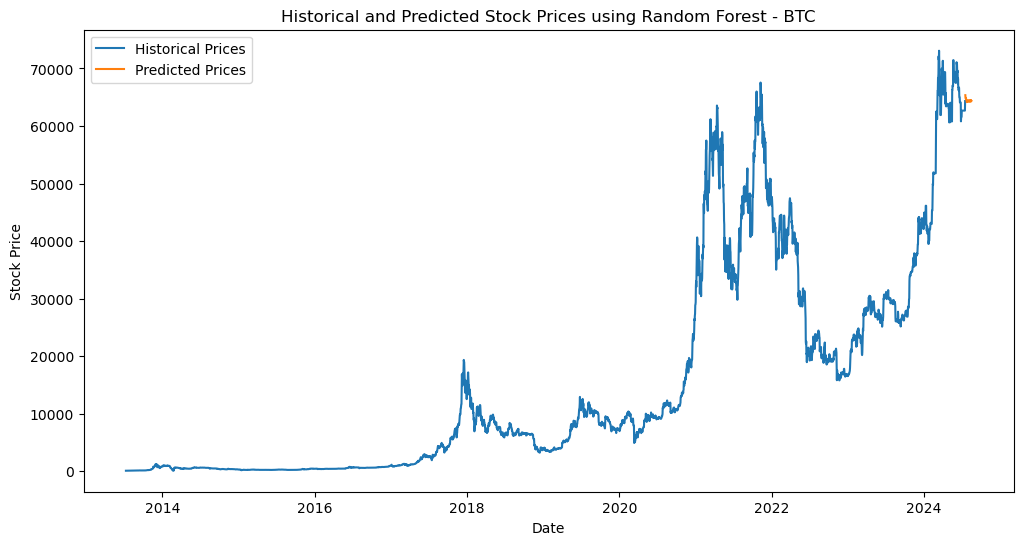

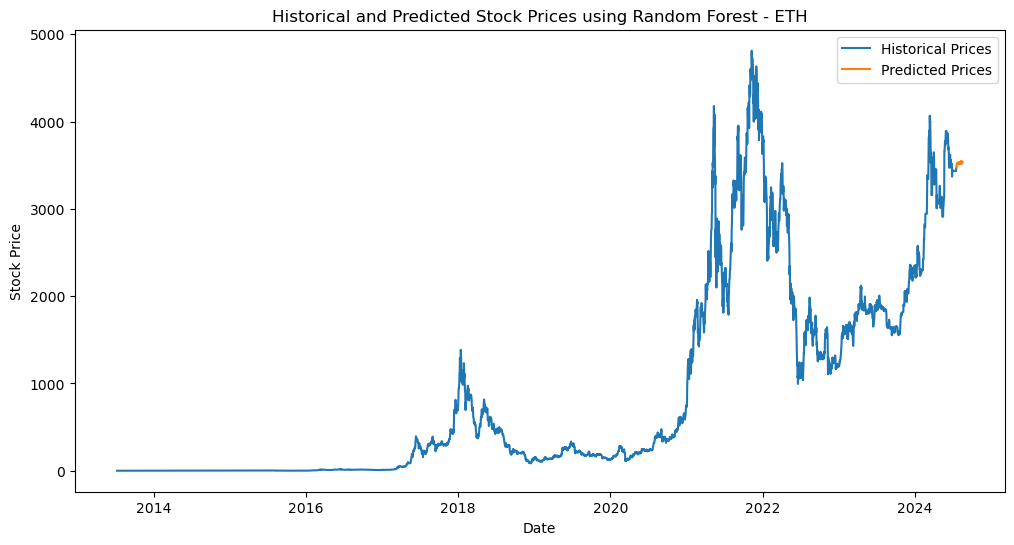

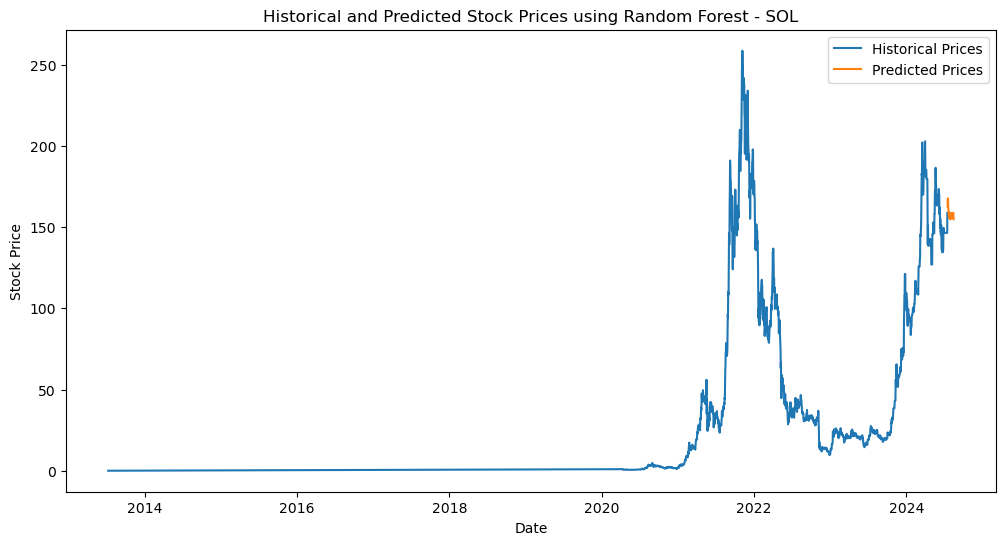

Historical and predicted stock prices plotted.


In [8]:
# Cell 8: Plot historical and predicted stock prices
for crypto, future_df in crypto_future_predictions.items():
    plt.figure(figsize=(12, 6))
    plt.title(f'Historical and Predicted Stock Prices using Random Forest - {crypto}')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.plot(crypto_data[crypto]['Close'], label='Historical Prices')
    plt.plot(future_df.index, future_df['Predicted_Close'], label='Predicted Prices')
    plt.legend()
    plt.savefig(f'../results/{crypto}_rf_predict.png')
    plt.show()
print("Historical and predicted stock prices plotted.")


In [9]:
# Cell 9: Print feature importances
for crypto, model in crypto_models.items():
    feature_list = [f'Close_Lag{i}' for i in range(1, 8)]
    importances = model.feature_importances_
    feature_importances = sorted(zip(feature_list, importances), key=lambda x: x[1], reverse=True)
    print(f"\n{crypto} Feature Importances:")
    for feature, importance in feature_importances:
        print(f'Variable: {feature:20} Importance: {importance:.2f}')



BTC Feature Importances:
Variable: Close_Lag1           Importance: 0.99
Variable: Close_Lag2           Importance: 0.00
Variable: Close_Lag5           Importance: 0.00
Variable: Close_Lag3           Importance: 0.00
Variable: Close_Lag7           Importance: 0.00
Variable: Close_Lag6           Importance: 0.00
Variable: Close_Lag4           Importance: 0.00

ETH Feature Importances:
Variable: Close_Lag1           Importance: 0.99
Variable: Close_Lag2           Importance: 0.01
Variable: Close_Lag4           Importance: 0.00
Variable: Close_Lag3           Importance: 0.00
Variable: Close_Lag7           Importance: 0.00
Variable: Close_Lag5           Importance: 0.00
Variable: Close_Lag6           Importance: 0.00

SOL Feature Importances:
Variable: Close_Lag1           Importance: 0.96
Variable: Close_Lag2           Importance: 0.04
Variable: Close_Lag3           Importance: 0.00
Variable: Close_Lag7           Importance: 0.00
Variable: Close_Lag5           Importance: 0.00
Variable: 

In [10]:
# Cell 10: Save the trained models for all cryptocurrencies
for crypto, model in crypto_models.items():
    model_path = f'../models/{crypto}_random_forest_model.pkl'
    joblib.dump(model, model_path)
    print(f"Model saved for {crypto} at {model_path}")


Model saved for BTC at ../models/BTC_random_forest_model.pkl
Model saved for ETH at ../models/ETH_random_forest_model.pkl
Model saved for SOL at ../models/SOL_random_forest_model.pkl
